#  Project Title: Customer Segmentation and Sales Forecasting System for an Online Retailer

- https://archive.ics.uci.edu/dataset/352/online+retail

#### Dataset Information
- This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.





### Variables Table

| Variable Name | Role     | Type        | Description                                                               | Units    |
|---------------|----------|-------------|---------------------------------------------------------------------------|----------|
| InvoiceNo     | ID       | Categorical | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation |          |
| StockCode     | ID       | Categorical | A 5-digit integral number uniquely assigned to each distinct product      |          |
| Description   | Feature  | Categorical | Product name                                                              |          |
| Quantity      | Feature  | Integer     | The quantities of each product (item) per transaction                     |          |
| InvoiceDate   | Feature  | Date        | The day and time when each transaction was generated                      |          |
| UnitPrice     | Feature  | Continuous  | Product price per unit                                                    | Sterling |
| CustomerID    | Feature  | Categorical | A 5-digit integral number uniquely assigned to each customer              |          |
| Country       | Feature  | Categorical | The name of the country where each customer resides                       |          |


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing and inspecting the Data 

In [3]:
# data = pd.read_excel('C:\\Users\\Abdellah1\\Desktop\\dataScience notebooks\\Online Retail\\Online Retail.xlsx')
data = pd.read_excel('Online Retail.xlsx')

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:

print(F"The data shape is  {data.shape}")
print(F"-----------------------------------------")
print(F"{data.info()}")


The data shape is  (541909, 8)
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [6]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [7]:
data.describe(include=['object'])

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


In [8]:
#checking for duplicates
print(data.duplicated().sum())

5268


In [9]:
# checking for null values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

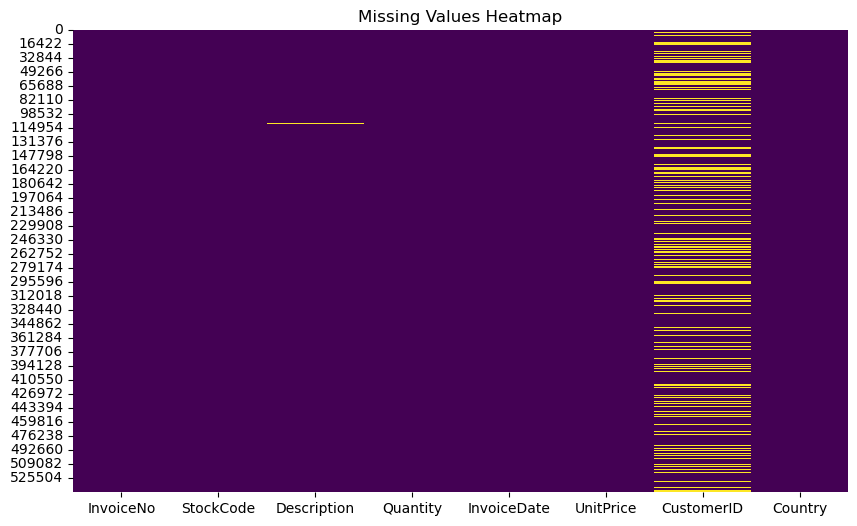

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

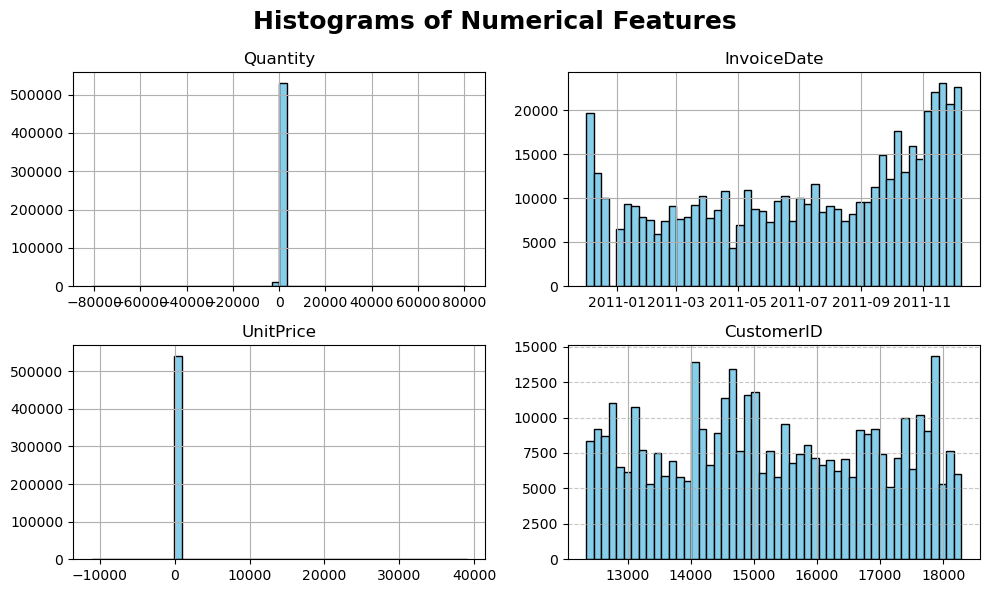

In [11]:
data.hist(
    bins=50, 
    figsize=(10, 6), 
    color='skyblue',  
    edgecolor='black'  
)

plt.suptitle('Histograms of Numerical Features', fontsize=18, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

- Quantity: Shows a highly skewed distribution with most values concentrated near zero, but there are extreme outliers on both the negative and positive sides.
- InvoiceDate: Displays the frequency of transactions over time, with a steady increase in transactions toward the end of the dataset's time range.
- UnitPrice: Similar to Quantity, it is highly skewed, with most values near zero and a few extreme outliers.
- CustomerID: Shows the distribution of customer IDs, with some IDs appearing more frequently than others.

In [12]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

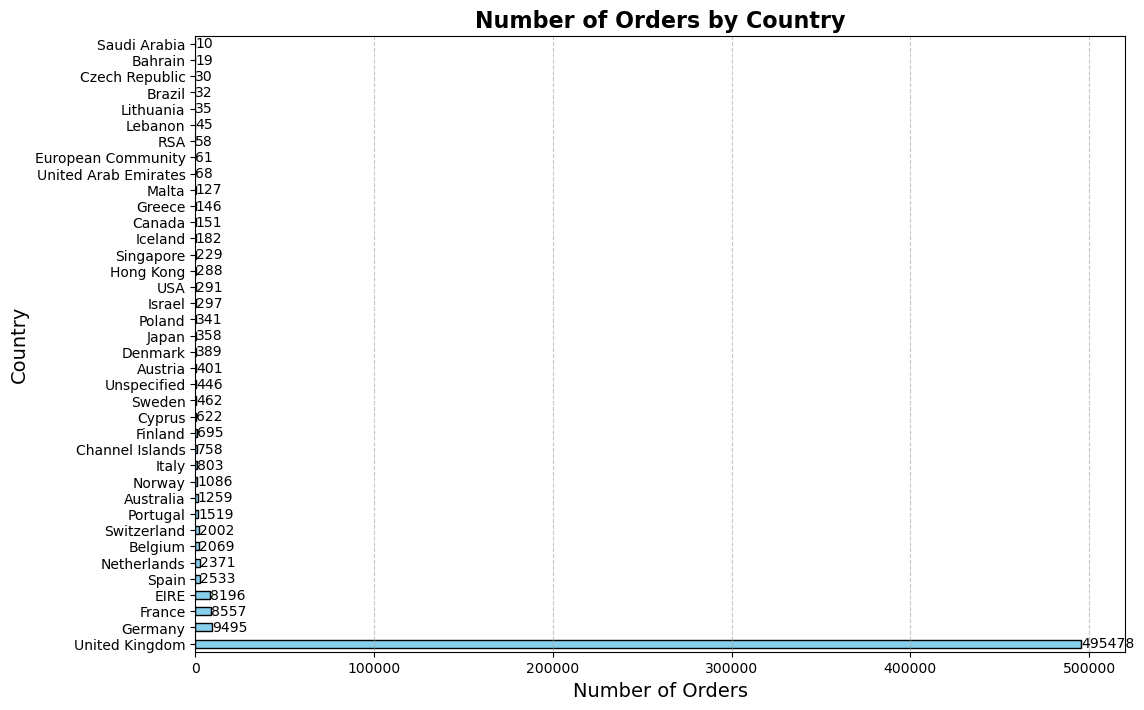

In [13]:
# Plot the bar chart
country_counts = data['Country'].value_counts()
ax = country_counts.plot(kind='barh', figsize=(12, 8), color='skyblue', edgecolor='black')

# Add annotations (numbers) to the bars
for i, value in enumerate(country_counts):
    plt.text(value + 10, i, str(value), va='center', fontsize=10)  # Adjust `+10` for spacing

# Add titles and labels
plt.title('Number of Orders by Country', fontsize=16, fontweight='bold')
plt.xlabel('Number of Orders', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

#### Checking for Outliers

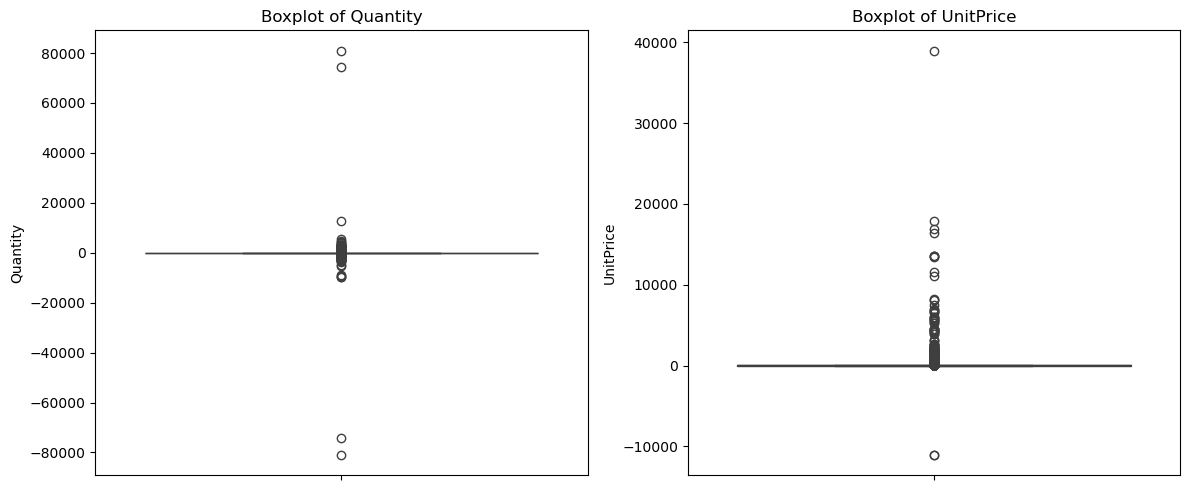

In [14]:
numeric_cols = ['Quantity', 'UnitPrice']

def plot_outliers(data, numeric_cols):
    fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(12, 5))

    # Create boxplots
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()
plot_outliers(data, numeric_cols)


## Data preprocessing

In [15]:
preProcessed_data = data.copy()

- remove duplicates and nulls

In [16]:
preProcessed_data.dropna(inplace=True)
preProcessed_data.drop_duplicates(inplace=True)

### Feature engneering

In [17]:
preProcessed_data['TotalPrice'] = preProcessed_data['Quantity'] * preProcessed_data['UnitPrice']
preProcessed_data['TotalPrice'] = preProcessed_data['TotalPrice'].astype(float)

- splite date

In [18]:
preProcessed_data['Year'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.year
preProcessed_data['Month'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.month
preProcessed_data['Day'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.day
preProcessed_data['Hour'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.hour
preProcessed_data['InvoiceDate'] = pd.to_datetime(preProcessed_data['InvoiceDate'])

### Outliers Handling

In [19]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count the number of records to be removed
    initial_count = df.shape[0]
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    removed_count = initial_count - filtered_df.shape[0]
    
    # Print the count of removed records
    print(f"Removed {removed_count} outliers from column '{column}'")
    
    return filtered_df

#### create a version with no outliers

In [20]:
preProcessed_data_with_noOutliers = remove_outliers(preProcessed_data, 'Quantity')
preProcessed_data_with_noOutliers = remove_outliers(preProcessed_data_with_noOutliers, 'UnitPrice')

Removed 26646 outliers from column 'Quantity'
Removed 35505 outliers from column 'UnitPrice'


Removed 15675 outliers from column 'UnitPrice'


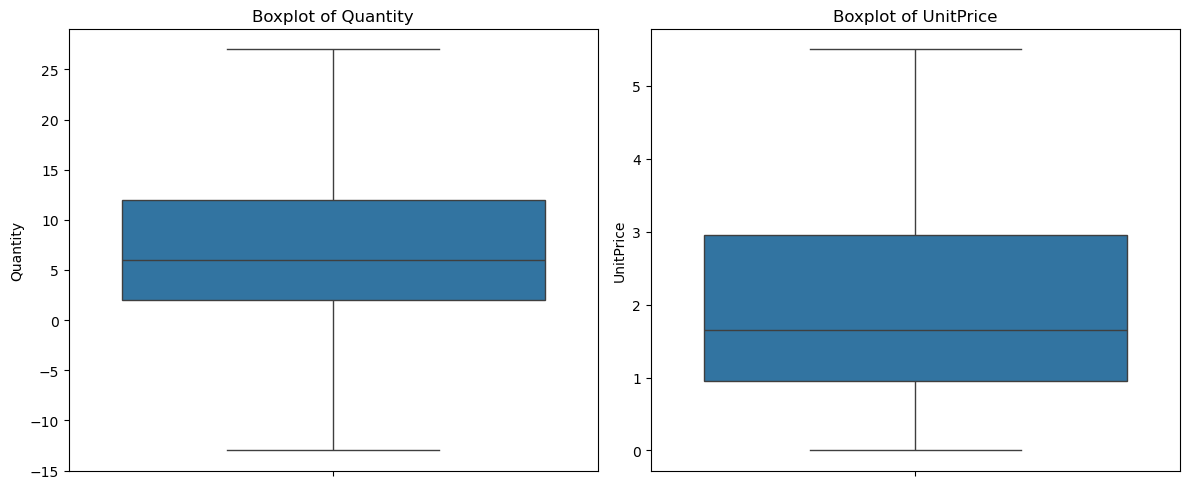

In [21]:
preProcessed_data_with_noOutliers = remove_outliers(preProcessed_data_with_noOutliers, 'UnitPrice')
plot_outliers(preProcessed_data_with_noOutliers, numeric_cols)

## Time series analysis

In [22]:

df = preProcessed_data.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().to_frame()

In [23]:
df = preProcessed_data_with_noOutliers.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
daily_sales_noOutliers = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().to_frame()

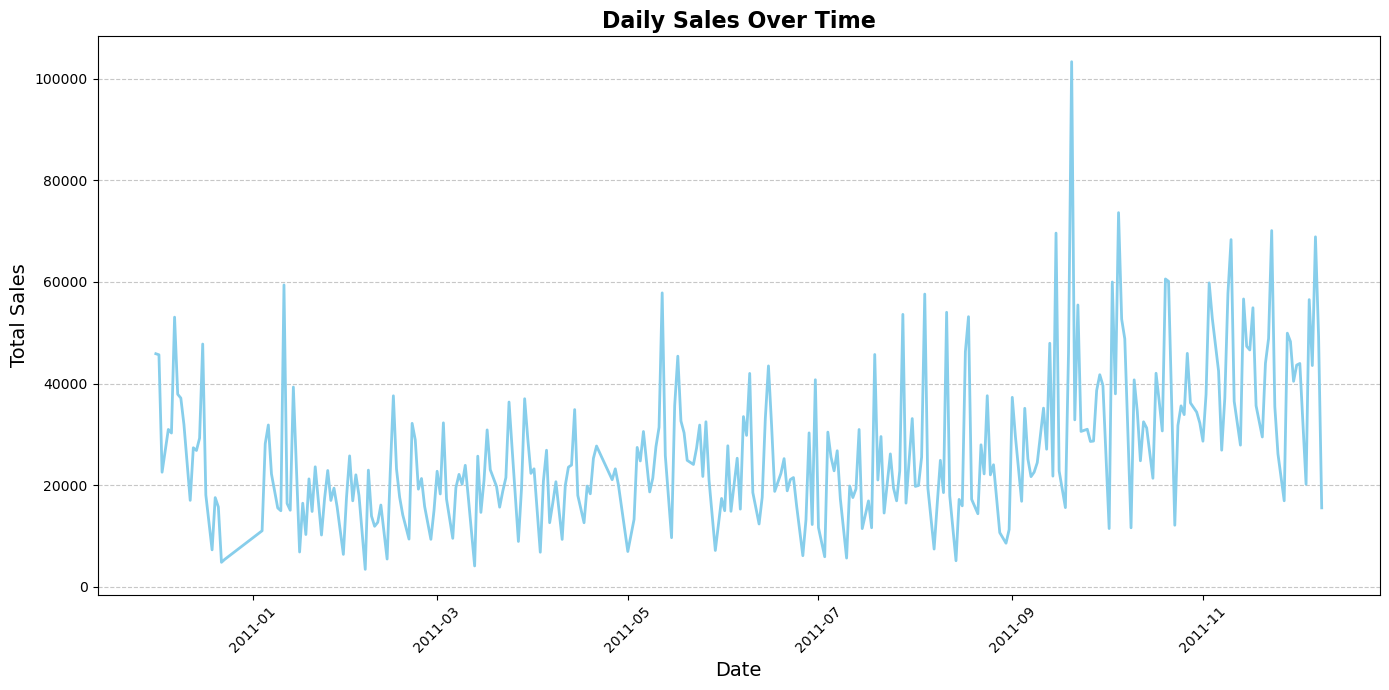

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(daily_sales.index, daily_sales['TotalPrice'], color='skyblue', linewidth=2)
plt.title('Daily Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

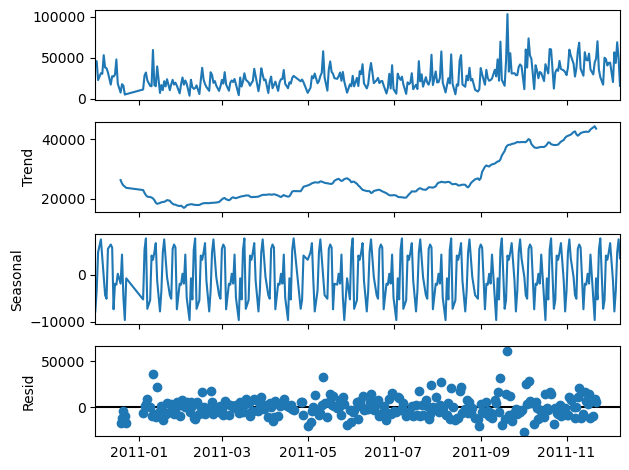

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_sales, model='additive',period=30)
decomposition.plot()
plt.show()

In [26]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(daily_sales.dropna())

# Print the ADF statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check if the series is stationary
if result[1] < 0.05:
    print("The time series is stationary (p-value < 0.05).")
else:
    print("The time series is not stationary (p-value >= 0.05).")

ADF Statistic: -1.2435991215409237
p-value: 0.6545650745327601
The time series is not stationary (p-value >= 0.05).


### Analyize residuals

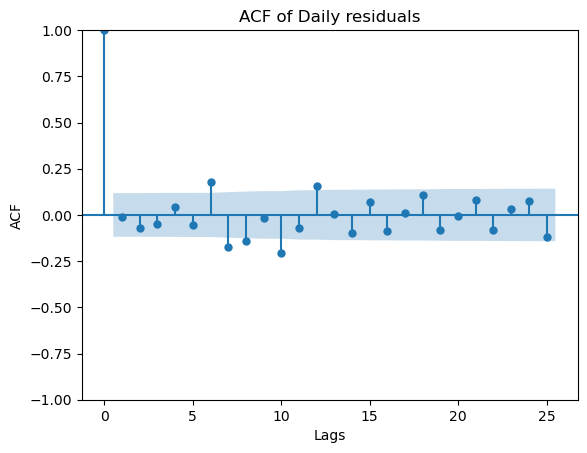

In [27]:

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(decomposition.resid.dropna())
plt.title('ACF of Daily residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

- The ACF plot suggests that the residuals are mostly random, which is a positive outcome. However, the small significant lags indicate there might still be minor patterns left to address. Further analysis (e.g., stationarity testing or residual modeling) can help refine the results.

In [28]:

result = adfuller(decomposition.resid.dropna())

# Print the ADF statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check if the series is stationary
if result[1] < 0.05:
    print("The resid is stationary (p-value < 0.05).")
else:
    print("The resid is not stationary (p-value >= 0.05).")

ADF Statistic: -8.238804879406427
p-value: 5.791814401807691e-13
The resid is stationary (p-value < 0.05).


## Time forcasting

### ARIMA MODEL

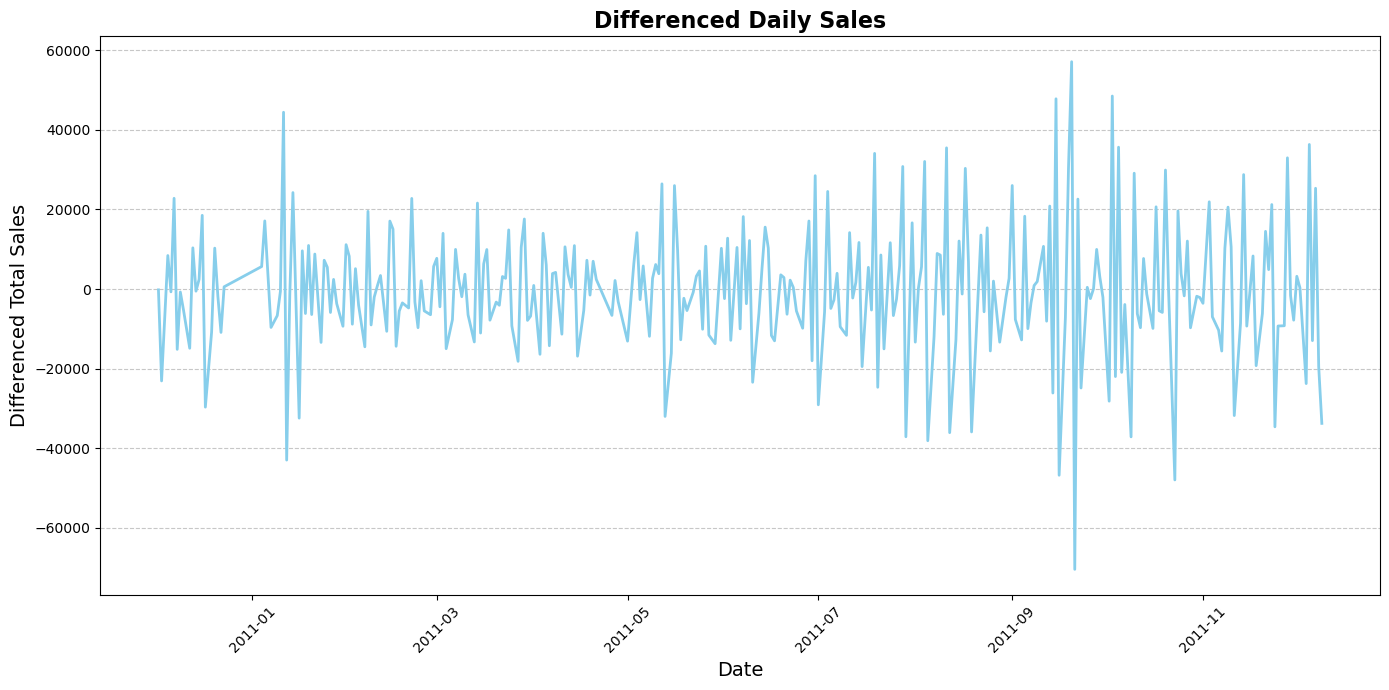

In [29]:
# since daily_sales is not stationary, we will use the differencing method to make it stationary
daily_sales['diff'] = daily_sales['TotalPrice'].diff()
# Drop the first row with NaN value
daily_sales.dropna(inplace=True)
# Plot the differenced series
plt.figure(figsize=(14, 7))
plt.plot(daily_sales.index, daily_sales['diff'], color='skyblue', linewidth=2)
plt.title('Differenced Daily Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Total Sales', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



 Since the time series is stationary, we will difference the data to use it in the ARIMA model
- the goal is to find the parameter for the ARIMA model

In [30]:
# Perform the ADF test on the differenced series
daily_sales['diff'] = daily_sales['diff'].dropna()
result = adfuller(daily_sales['diff'].dropna())
# Print the ADF statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# Check if the series is stationary
if result[1] < 0.05:
    print("The differenced series is stationary (p-value < 0.05).")
else:
    print("The differenced series is not stationary (p-value >= 0.05).")


ADF Statistic: -9.311957787432215
p-value: 1.0432673656373302e-15
The differenced series is stationary (p-value < 0.05).


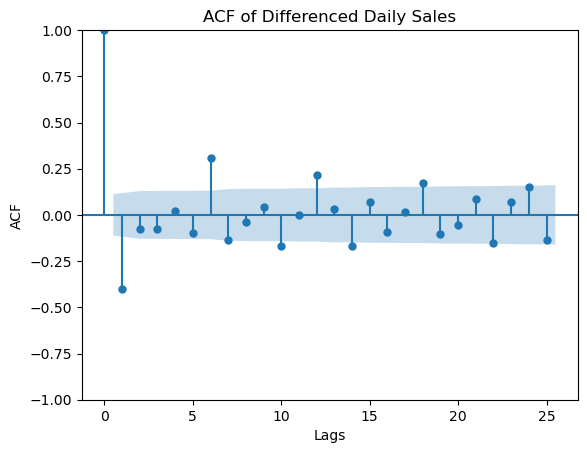

In [31]:
## choose the p and q values using ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_pacf
# Plot ACF
plot_acf(daily_sales['diff'])
plt.title('ACF of Differenced Daily Sales')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()


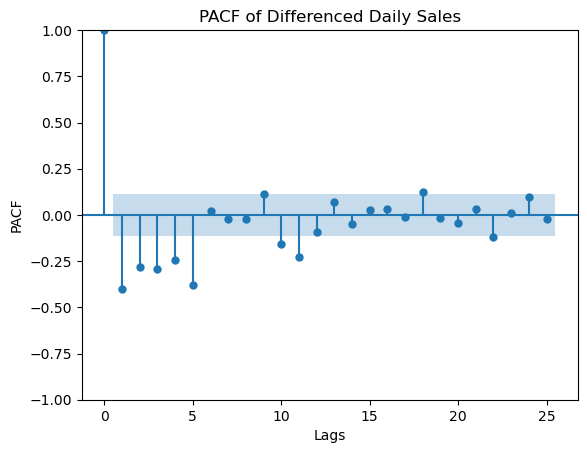

In [32]:
# Plot PACF
plot_pacf(daily_sales['diff'])
plt.title('PACF of Differenced Daily Sales')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [33]:
daily_sales

,TotalPrice,diff
InvoiceDate,,
2010-12-02,45656.47,-210.79
2010-12-03,22553.38,-23103.09
2010-12-05,30970.28,8416.90
2010-12-06,30258.77,-711.51
2010-12-07,53061.64,22802.87
...,...,...
2011-12-05,56513.41,36337.06
2011-12-06,43540.22,-12973.19
2011-12-07,68867.66,25327.44


In [34]:
## auto_arima to choose the best p and q values
# from pmdarima import auto_arima

# auto_model = auto_arima(daily_sales['diff'], seasonal=False, stepwise=True)
# print(auto_model.summary())


#### Fitting the model

In [35]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(decomposition.resid.dropna(), order=(1, 0, 1))  # d=0 because residual is already differenced
fitted_model = model.fit()
print(fitted_model.summary())


c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  275
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2930.016
Date:                Sat, 17 May 2025   AIC                           5868.031
Time:                        08:22:43   BIC                           5882.499
Sample:                             0   HQIC                          5873.838
                                - 275                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -54.1238     52.802     -1.025      0.305    -157.614      49.366
ar.L1          0.8509      0.037     22.998      0.000       0.778       0.923
ma.L1         -0.9998      0.065    -15.439      0.0

#### Trying to predict the resid using ARIMA

In [36]:
# Train/test split
train = daily_sales['TotalPrice'][:90]
test = daily_sales['TotalPrice'][90:]

In [37]:
forecast_resid = fitted_model.forecast(steps=len(test))


c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [38]:
# Get matching trend and seasonal components
trend_part = decomposition.trend.dropna()[-len(forecast_resid):]
seasonal_part = decomposition.seasonal[-len(forecast_resid):]

# Add them to residual forecast
final_forecast = forecast_resid + trend_part.values + seasonal_part.values


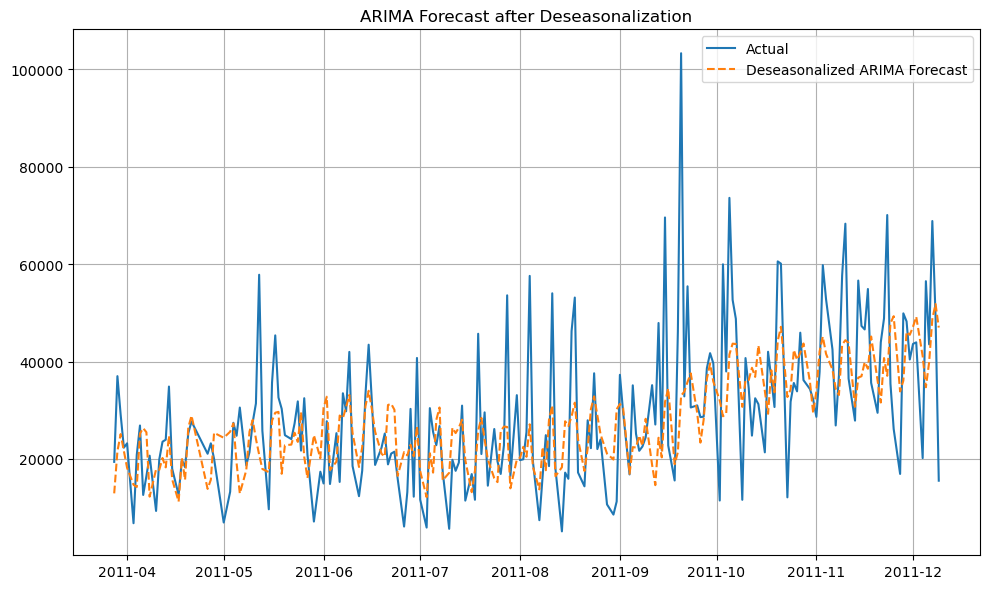

In [39]:
plt.figure(figsize=(10,6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, final_forecast, label='Deseasonalized ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast after Deseasonalization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Captures overall direction:

The forecasted line shows rising trends when actual sales increase — suggesting that the trend and seasonality components were re-added correctly.


What Still Needs Attention
Forecast underestimates extreme spikes:

The model smooths out the data and can’t fully capture sharp peaks (e.g., sudden spikes above 80k–100k).

This is expected from ARIMA, which is best at modeling consistent, linear-ish behavior — not outliers or shock events.

### Try the same approach without outliers and apply:
- smoothing 
- seasonal order (which is make it SARIMA)

In [75]:
# Trying the Arima model with smoothed data and no outliers
df = preProcessed_data_with_noOutliers.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date


data_with_noOutliers_smoothed = df.groupby(['InvoiceDate']).agg({'TotalPrice': 'sum'})


In [76]:
## smoothing the data
data_with_noOutliers_smoothed['TotalPrice'] = data_with_noOutliers_smoothed['TotalPrice'].rolling(window=7).mean()
data_with_noOutliers_smoothed.dropna(inplace=True)


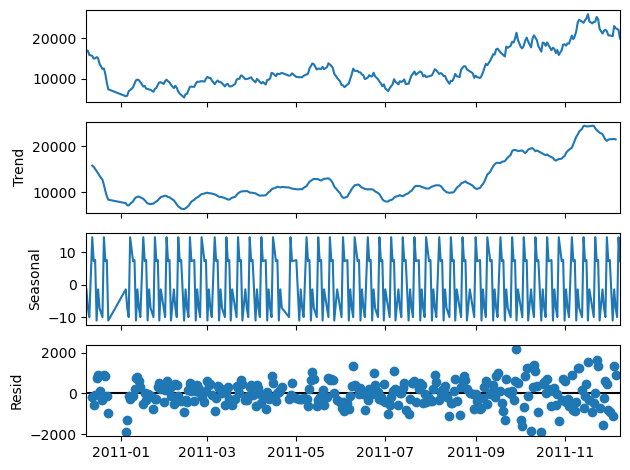

In [77]:
# decompose the smoothed series
decomposition_smooth = seasonal_decompose(data_with_noOutliers_smoothed, model='additive', period=7)
decomposition_smooth.plot()
plt.show()

In [78]:
# # get the optimal ARIMA model using auto_arima
from pmdarima import auto_arima
auto_model = auto_arima(data_with_noOutliers_smoothed['TotalPrice'], seasonal=True, m=7, stepwise=True)
print(auto_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  299
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -2346.589
Date:                                Sat, 17 May 2025   AIC                           4707.179
Time:                                        11:52:31   BIC                           4733.059
Sample:                                             0   HQIC                          4717.538
                                                - 299                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     61.7001     17.130      3.602      0.000      28.125      95.275
ma.

In [87]:
# predict the smoothed residuals using an ARIMA model
model = ARIMA(decomposition_smooth.resid.dropna(), order=(0, 1, 1), seasonal_order=(2, 0, [1,2], 7))
fitted_model = model.fit()
print(fitted_model.summary())


c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                resid   No. Observations:                  293
Model:             ARIMA(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -2210.234
Date:                              Sat, 17 May 2025   AIC                           4432.469
Time:                                      12:06:46   BIC                           4454.529
Sample:                                           0   HQIC                          4441.305
                                              - 293                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9969      0.147     -6.792      0.000      -1.285      -0.709
ar.S.L7       -0.94

c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


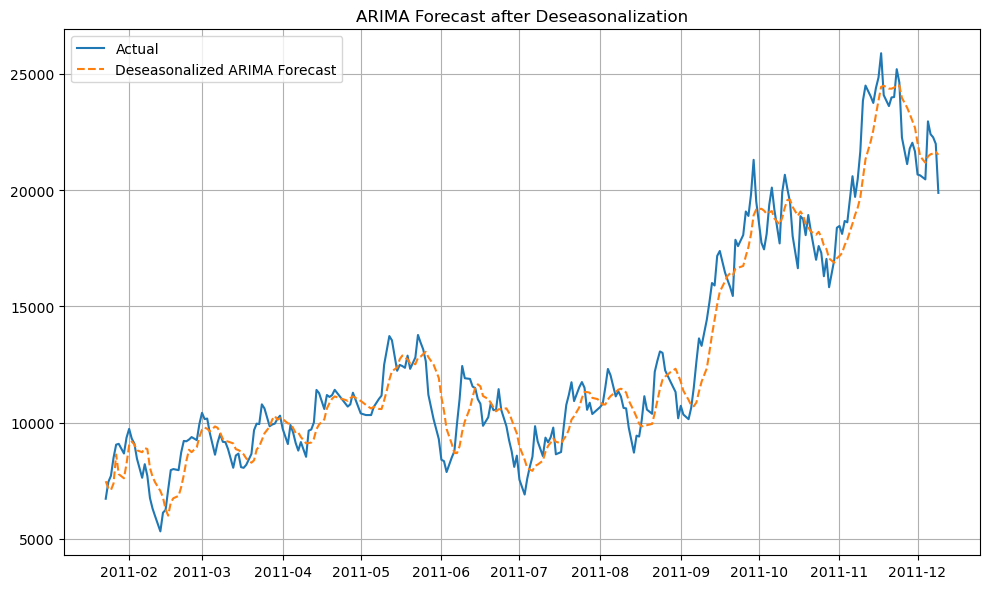

In [88]:
train = data_with_noOutliers_smoothed['TotalPrice'][:30]
test = data_with_noOutliers_smoothed['TotalPrice'][30:]
forecast_resid = fitted_model.forecast(steps=len(test))
# Get matching trend and seasonal components
trend_part = decomposition_smooth.trend.dropna()[-len(forecast_resid):]
seasonal_part = decomposition_smooth.seasonal[-len(forecast_resid):]
# Add them to residual forecast
final_forecast = forecast_resid + trend_part.values + seasonal_part.values
plt.figure(figsize=(10,6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, final_forecast, label='Deseasonalized ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast after Deseasonalization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
from sklearn.metrics import r2_score

r2 = r2_score(test, final_forecast)
print(f"R-squared: {r2}")

R-squared: 0.9483835233372504


#### Forecast for the next 180 days


In [103]:
future_steps = 180
future_forecast_resid = fitted_model.forecast(steps=future_steps)

# Extend trend and seasonal components
future_trend = decomposition_smooth.trend.dropna()[-future_steps:]
future_seasonal = decomposition_smooth.seasonal[-future_steps:]

# Combine components
future_final_forecast = future_forecast_resid + future_trend.values + future_seasonal.values

c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Abdellah1\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


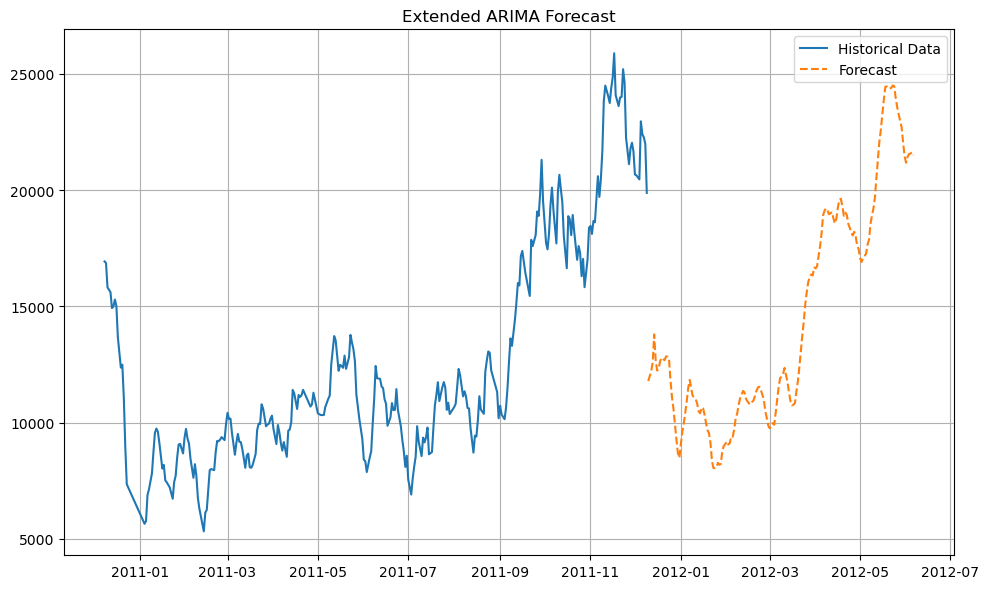

In [104]:
# Create a date range for the forecast
future_dates = pd.date_range(
    start=data_with_noOutliers_smoothed.index[-1],  # Start from the last date in the historical data
    periods=future_steps + 1,                      # Include the number of forecast steps
    freq='D'                                       # Assuming daily frequency
)[1:]                                              # Exclude the start date (already in historical data)

# Plot the forecast with proper dates
plt.figure(figsize=(10, 6))
plt.plot(data_with_noOutliers_smoothed.index, data_with_noOutliers_smoothed['TotalPrice'], label='Historical Data')
plt.plot(future_dates, future_final_forecast, label='Forecast', linestyle='--')
plt.title('Extended ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()